<a id =000> </a> <br>
***

# <center> <span style="color:blue;background:yellow"> [India ML Hiring Hackathon 2019](https://datahack.analyticsvidhya.com/contest/india-ml-hiring-hackathon-2019/) </span></center>

![](images/India_ml.png)

#### Read [README](https://github.com/dc-aichara/competitions/tree/master/AV) for more info. 
*** 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import f1_score
import lightgbm as lgb
import catboost as cgb
from datetime import datetime, timedelta

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

/Users/0030/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### <center> <span style="color:blue;background:yellow"> Data Dictionary

| Variable | Description |
| ------ | ------ |
|loan_id|Unique loan ID|
|source	|Loan origination channel|
|financial_institution	|Name of the bank|
|interest_rate	|Loan interest rate|
|unpaid_principal_bal	|Loan unpaid principal balance|
|loan_term	|Loan term (in days)|
|origination_date	|Loan origination date (YYYY-MM-DD)|
|first_payment_date	|First instalment payment date |
|loan_to_value	 |Loan to value ratio |
|number_of_borrowers	 |Number of borrowers |
|debt_to_income_ratio	 | Debt-to-income ratio |
|borrower_credit_score	 | Borrower credit score |
|loan_purpose	| Loan purpose |
|insurance_percent	 | Loan Amount percent covered by insurance |
|co-borrower_credit_score	 | Co-borrower credit score |
|insurance_type	 | 0 - Premium paid by borrower, 1 - Premium paid by Lender
|m1 to m12	 | Month-wise loan performance (deliquency in months)　|　
|m13|target, loan deliquency status (0 = non deliquent, 1 = deliquent)　|

In [2]:
# load Data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print('Shape of train Data :', train.shape, '\n Shape of test data :', test.shape)

Shape of train Data : (116058, 29) 
 Shape of test data : (35866, 28)


In [4]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [5]:
train['m13'].value_counts().plot(kind='bar')

In [6]:
print('Defaulter percentage :', train['m13'].value_counts()[1]/train['m13'].value_counts().sum()*100 , '%')

Defaulter percentage : 0.5480018611383963 %


In [7]:
train_id = train['loan_id']
test_id = ['load_id']
target = train['m13']
train.drop(['loan_id','m13'], axis=1, inplace=True)
test.drop('loan_id', axis=1, inplace=True)

In [8]:
cat_cols = ['source', 'financial_institution', 'loan_purpose']
date_col = ['origination_date', 'first_payment_date']

In [9]:
def onehotencode(df):
    enc = OneHotEncoder(handle_unknown='ignore')
    df_cat = df[cat_cols]
    enc.fit(df_cat)
    df_cat = pd.DataFrame(enc.transform(df_cat).toarray())
    cat_col2 = df_cat.columns.tolist()
    for i in range(len(cat_col2)):
        cat_col2[i] = 'f' + str(cat_col2[i]) 
    df_cat.columns = cat_col2
    df = pd.concat([df, df_cat], axis=1)
    df.drop(cat_cols, axis=1, inplace=True)
    
    return df,cat_col2  
train, cat_col2  = onehotencode(train)
test, cat_col2  = onehotencode(test)

In [10]:
train.head()

,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
# Date columns 
test['first_payment_date'] = test['first_payment_date'].apply(lambda x: x[:-2] + '2012')
def process_date_cols(df):
#     df_date = df[date_col]
    for col in date_col:
        df[col]=pd.to_datetime(df[col])
    df['days_to_first_payment'] = (pd.to_datetime(df['first_payment_date'])-pd.to_datetime(df['origination_date']))
    df['days_to_first_payment'] = df['days_to_first_payment'].apply(lambda x:x.days)
    df['origin_year'] = df['origination_date'].apply(lambda x:x.year)
    df['origin_month'] = df['origination_date'].apply(lambda x:x.month)
    df['origin_day'] = df['origination_date'].apply(lambda x:x.month)
    df['payment_year'] = df['first_payment_date'].apply(lambda x:x.year)
    df['payment_month'] = df['first_payment_date'].apply(lambda x:x.month)
    df.drop(date_col, axis=1, inplace=True)
    return df

train = process_date_cols(train)
test = process_date_cols(test) 

In [12]:
train.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,f21,f22,f23,f24,days_to_first_payment,origin_year,origin_month,origin_day,payment_year,payment_month
0,4.250,214000,360,95,1.0,22.0,694.0,30.0,0.0,0.0,...,1.0,0.0,0.0,1.0,61,2012,3,3,2012,5
1,4.875,144000,360,72,1.0,44.0,697.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,60,2012,1,1,2012,3
2,3.250,366000,180,49,1.0,33.0,780.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,60,2012,1,1,2012,3
3,4.750,135000,360,46,2.0,44.0,633.0,0.0,638.0,0.0,...,0.0,0.0,1.0,0.0,60,2012,2,2,2012,4
4,4.750,124000,360,80,1.0,43.0,681.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,60,2012,2,2,2012,4


In [13]:
test.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,f21,f22,f23,f24,days_to_first_payment,origin_year,origin_month,origin_day,payment_year,payment_month
0,3.875,417000,360,75,1,20,790,0,0,0,...,0.0,1.0,0.0,0.0,90,2012,1,1,2012,4
1,4.500,113000,360,80,2,33,793,0,784,0,...,0.0,0.0,0.0,1.0,90,2012,1,1,2012,4
2,4.500,72000,360,75,1,34,710,0,0,0,...,0.0,0.0,0.0,1.0,60,2012,1,1,2012,3
3,4.125,123000,180,41,2,24,798,0,813,0,...,0.0,1.0,0.0,0.0,90,2012,1,1,2012,4
4,3.250,166000,180,53,2,12,767,0,768,0,...,0.0,1.0,0.0,0.0,90,2012,1,1,2012,4


In [14]:
m_cols = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']

In [16]:
def feat_eng1(df):
    df['m_mean'] = df[m_cols].mean(axis=1)
    df['m_sum'] = df[m_cols].sum(axis=1)
    df['m_std'] = df[m_cols].std(axis=1)
    df['interest'] = df.apply(lambda x: (x.interest_rate*x.unpaid_principal_bal*x.loan_to_value)/(12*100), axis=1)
    df['dir_lv_nb'] = df.apply(lambda x: (x.debt_to_income_ratio*x.number_of_borrowers)/(x.loan_to_value), axis=1)
    return df

train = feat_eng1(train)
test = feat_eng1(test)


In [17]:
train.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,origin_year,origin_month,origin_day,payment_year,payment_month,m_mean,m_sum,m_std,interest,dir_lv_nb
0,4.250,214000,360,95,1.0,22.0,694.0,30.0,0.0,0.0,...,2012,3,3,2012,5,0.083333,1,0.288675,72002.083333,0.231579
1,4.875,144000,360,72,1.0,44.0,697.0,0.0,0.0,0.0,...,2012,1,1,2012,3,0.083333,1,0.288675,42120.000000,0.611111
2,3.250,366000,180,49,1.0,33.0,780.0,0.0,0.0,0.0,...,2012,1,1,2012,3,0.000000,0,0.000000,48571.250000,0.673469
3,4.750,135000,360,46,2.0,44.0,633.0,0.0,638.0,0.0,...,2012,2,2,2012,4,0.333333,4,0.492366,24581.250000,1.913043
4,4.750,124000,360,80,1.0,43.0,681.0,0.0,0.0,0.0,...,2012,2,2,2012,4,5.500000,66,3.605551,39266.666667,0.537500


In [18]:
test.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,origin_year,origin_month,origin_day,payment_year,payment_month,m_mean,m_sum,m_std,interest,dir_lv_nb
0,3.875,417000,360,75,1,20,790,0,0,0,...,2012,1,1,2012,4,0.0,0,0.0,100992.187500,0.266667
1,4.500,113000,360,80,2,33,793,0,784,0,...,2012,1,1,2012,4,0.0,0,0.0,33900.000000,0.825000
2,4.500,72000,360,75,1,34,710,0,0,0,...,2012,1,1,2012,3,0.0,0,0.0,20250.000000,0.453333
3,4.125,123000,180,41,2,24,798,0,813,0,...,2012,1,1,2012,4,0.0,0,0.0,17335.312500,1.170732
4,3.250,166000,180,53,2,12,767,0,768,0,...,2012,1,1,2012,4,0.0,0,0.0,23827.916667,0.452830


In [19]:
cat_features = cat_col2 + m_cols 

In [20]:
# train1 = train.drop(['origination_date', 'first_payment_date'], axis=1)
# test1 = test.drop(['origination_date', 'first_payment_date'], axis=1)

train1 =train
test1 = test

In [74]:
# penalty specifies the norm in the penalization
penalty = ['l1', 'l2']
# C is the inverese of regularization parameter
C = np.logspace(0, 7, 10)
random_state=[0]
# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, 
                  random_state=random_state)

model= LogisticRegression(random_state = 0)

clf = GridSearchCV(estimator = model, param_grid = hyperparameters, 
                   cv=15)
best_model = clf.fit(train1, target.values.ravel())
print('Best Penalty:', best_model.best_estimator_.get_params() ['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 5.99484250318941


In [76]:
pred = best_model.predict(test1)

In [77]:
sub = pd.read_csv('sample_submission.csv')

In [78]:
sub['m13'] = pred

In [79]:
sub.head()

,loan_id,m13
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [80]:
sub['m13'].value_counts()

0    35784
1       82
Name: m13, dtype: int64

In [81]:
sub.to_csv('sub1.csv', index=False)

In [82]:
print('Defaulter percentage :', sub['m13'].value_counts()[1]/sub['m13'].value_counts().sum()*100 , '%')

Defaulter percentage : 0.22862878492165284 %


# LGBM

In [21]:
def lgb_f1_score(preds, dtrain):
    y_true = dtrain.get_label()
    preds = np.round(preds)
    return 'f1', f1_score(y_true, preds), True

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(train1, target, train_size =0.80, random_state=10)

In [23]:
dtrain = lgb.Dataset(X_train, y_train, free_raw_data=False)
dvalid = lgb.Dataset(X_valid, y_valid, free_raw_data=False)
watchlist = [dtrain, dvalid]

In [24]:
param = {
    'n_estimators':1500,
    'num_leaves': 200,
    'feature_fraction': 0.4068,
    'bagging_fraction': 0.9927 ,
    'bagging_freq': 50,
    'max_depth': 17,
    'lambda_l1': 2.375,
    'lambda_l2':1.058,
    'min_split_gain':  0.008033,
    'min_child_weight': 42.77 ,
    'learing_rate':0.001,
     'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'auc',
    'is_unbalance': True,
    'boost_from_average': False,
}

[50]	train's auc: 0.996892	train's f1: 0.566391	val's auc: 0.922319	val's f1: 0.417085
[100]	train's auc: 0.999358	train's f1: 0.655633	val's auc: 0.918997	val's f1: 0.459302
[150]	train's auc: 0.999547	train's f1: 0.709366	val's auc: 0.910984	val's f1: 0.4875
[200]	train's auc: 0.999668	train's f1: 0.742075	val's auc: 0.906239	val's f1: 0.506494
[250]	train's auc: 0.999742	train's f1: 0.766369	val's auc: 0.904731	val's f1: 0.525253
[300]	train's auc: 0.999791	train's f1: 0.78566	val's auc: 0.903327	val's f1: 0.531469
[350]	train's auc: 0.999825	train's f1: 0.799069	val's auc: 0.902159	val's f1: 0.548043
[400]	train's auc: 0.999843	train's f1: 0.813586	val's auc: 0.900675	val's f1: 0.541516
[450]	train's auc: 0.999866	train's f1: 0.824	val's auc: 0.899979	val's f1: 0.557621
[500]	train's auc: 0.999882	train's f1: 0.833333	val's auc: 0.899268	val's f1: 0.552239
[550]	train's auc: 0.999897	train's f1: 0.840131	val's auc: 0.899114	val's f1: 0.548872
[600]	train's auc: 0.999912	train's f1:

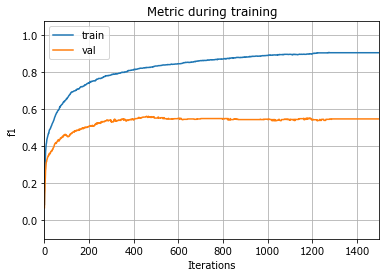

In [25]:
evals_result = {}

clf = lgb.train(param, dtrain, valid_sets=watchlist, valid_names=['train', 'val'],categorical_feature=cat_features,
                feval=lgb_f1_score, evals_result=evals_result, verbose_eval =50)

lgb.plot_metric(evals_result, metric='f1')

# Parameters Tuning


In [26]:
# Ojective Function
train_data = lgb.Dataset(data=train1, label=target, free_raw_data=False)
evals_result = {}
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': 1500, 'learning_rate':0.05, 'early_stopping_round':100, 'metric':'lgb_f1_score'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=5, seed=141, stratified=True,categorical_feature=cat_features,feval=lgb_f1_score, verbose_eval =500, metrics=['auc'])
        return max(cv_result['f1-mean'])

In [27]:
pbs = {'num_leaves': (100, 200),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (7, 21),
        'lambda_l1': (0, 5),
        'lambda_l2': (0, 2),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (1, 55)
      }

In [28]:
optimizer = BayesianOptimization(lgb_eval, pbs, random_state=7)
optimizer.maximize(init_points=5, n_iter=20, random_state=11)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.8153   |  0.7239   |  2.192    |  1.447    |  20.69    |  30.08    |  0.05061  |  107.2    |
|  2        |  0.4299   |  0.8537   |  0.4999   |  3.396    |  1.607    |  12.33    |  4.561    |  0.02953  |  191.0    |
|  3        |  0.0      |  0.8427   |  0.4617   |  4.656    |  0.0498   |  15.41    |  52.31    |  0.0238   |  154.8    |
|  4        |  0.0      |  0.9818   |  0.2065   |  2.617    |  1.501    |  16.37    |  26.26    |  0.02128  |  149.1    |
|  5        |  0.1085   |  0.8745   |  0.4819   |  1.829    |  1.676    |  17.76    |  17.96    |  0.05769  |  127.6    |
|  6        |  0.0      |  0.8      |  0.9      |  0.0      |  2.0      |  7.0      |  55.0     |  0.1      |  200.0    |
|  7        |  0.4402   

In [29]:
optimizer.max

{'target': 0.5024645216065584,
 'params': {'bagging_fraction': 1.0,
  'feature_fraction': 0.9,
  'lambda_l1': 5.0,
  'lambda_l2': 2.0,
  'max_depth': 7.0,
  'min_child_weight': 1.0,
  'min_split_gain': 0.001,
  'num_leaves': 123.0505984357637}}

In [30]:
p = optimizer.max['params']

In [31]:
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2':p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learing_rate':0.001,
         'objective': 'binary',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': {'lgb_f1_score'},
         'is_unbalance': True,
         'boost_from_average': False}


In [32]:
param

{'num_leaves': 123,
 'feature_fraction': 0.9,
 'bagging_fraction': 1.0,
 'max_depth': 7,
 'lambda_l1': 5.0,
 'lambda_l2': 2.0,
 'min_split_gain': 0.001,
 'min_child_weight': 1.0,
 'learing_rate': 0.001,
 'objective': 'binary',
 'boosting_type': 'gbdt',
 'verbose': 1,
 'metric': {'lgb_f1_score'},
 'is_unbalance': True,
 'boost_from_average': False}

In [33]:
%%time
nfold = 5
# target = 'm13'
predictors = train1.columns.values.tolist()

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2010)

oof = np.zeros(len(train1))
predictions = np.zeros(len(test1))

i = 1
for train_index, valid_index in skf.split(train['m12'], train['m12'].values):
    print("fold {}".format(i))
    xg_train = lgb.Dataset(train1.iloc[train_index],
                           label=target[train_index],
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train1.iloc[valid_index],
                           label=target[valid_index],
                           free_raw_data = False
                           )   
    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid],categorical_feature=cat_features,feval=lgb_f1_score, verbose_eval=100, early_stopping_rounds = 200)
    oof[valid_index] = clf.predict(train1.iloc[valid_index], num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(test1[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV F1-Score: {:<0.2f}".format(f1_score(target, np.round(oof))))

fold 1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.285211
[200]	valid_0's f1: 0.393443
[300]	valid_0's f1: 0.46595
[400]	valid_0's f1: 0.498024
[500]	valid_0's f1: 0.504
[600]	valid_0's f1: 0.504
Early stopping, best iteration is:
[470]	valid_0's f1: 0.506024
fold 2
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.255924
[200]	valid_0's f1: 0.4
[300]	valid_0's f1: 0.470588
[400]	valid_0's f1: 0.47012
Early stopping, best iteration is:
[292]	valid_0's f1: 0.485507
fold 3
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.282686
[200]	valid_0's f1: 0.412791
[300]	valid_0's f1: 0.501792
[400]	valid_0's f1: 0.546185
[500]	valid_0's f1: 0.534979
[600]	valid_0's f1: 0.534979
Early stopping, best iteration is:
[411]	valid_0's f1: 0.550607
fold 4
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.244328
[200]	valid_0's f1: 0.370588
[300]	valid_0's f1:

In [34]:
predictions

array([0.00656605, 0.00796676, 0.06445859, ..., 0.01049335, 0.00522162,
       0.00396115])

In [36]:
sub = pd.read_csv('data/sample_submission.csv')

In [37]:
sub['m13'] = predictions

sub['m13'] = sub['m13'].apply(lambda x:1 if x>=0.50 else 0)

sub['m13'].value_counts()

0    35708
1      158
Name: m13, dtype: int64

In [38]:
print('Defaulter percentage :', sub['m13'].value_counts()[1]/sub['m13'].value_counts().sum()*100 , '%')

Defaulter percentage : 0.4405286343612335 %


In [39]:
sub.to_csv('sub2.csv', index=False)